# Computational Methods in Economics

## Application: The RBC Model

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2019-01-28 18:53:55.661278


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import funapprox_cme as fa

--------------------------------------------------------------------------------------------------------------------------------

### Introduction

The *Real Business Cycle* (RBC) model is a staple of modern macroeconomics.

The RBC model is essentially a *stochastic* version of the NGM, which we have seen at multiple occasions in this course. It solves the following problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_{t} \right\}_{t = 0}^\infty} \mathbb{E} \sum^\infty_{t = 0} \beta^t \left[\frac{c_t^{1 - \nu}}{1 - \nu} - B \frac{h_t^{1+\eta}}{1+\eta}\right]
\end{equation}

s.t.

\begin{equation}
    c_t + k_{t + 1} =  z_t A k_t^\alpha h_{t}^{1-\alpha} + (1 - \delta) k_t
\end{equation}

where $z_t$ is a random variable capturing "productivity shocks". 

Below, we will see two approaches to solving the problem, depending on whether we model $z_t$ as a discrete or continuous random variable. The former choice simplifies the solution of the model, while the second one is more realistic.

--------------------------------------------------------------------------------------------------------------------------------

### "Simple" Approach: Discrete Random Variable

Consider the problem above:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_{t} \right\}_{t = 0}^\infty} \mathbb{E} \sum^\infty_{t = 0} \beta^t \left[\frac{c_t^{1 - \nu}}{1 - \nu} - B \frac{h_t^{1+\eta}}{1+\eta}\right]
\end{equation}

s.t.

\begin{equation}
    c_t + k_{t + 1} =  z_t A k_t^\alpha h_{t}^{1-\alpha} + (1 - \delta) k_t
\end{equation}

and assume that $z_t \in \{0.98, 1.02\}$. 

In other words, $z_t$ is a discrete random variable whose "support" consists of two values, a low state $z_0 = 0.98$ and a high state $z_1 = 1.02$.

We assume that these states are "persistent" in the sense that if the economy is in one state in period $t$, it is more likely to be in the same state in period $t+1$, rather than to moving to a different state. 

We can formalize this with a *probability transition matrix*:

\begin{equation}
    P =  \left[\begin{array}{cc}
    p_{00} & p_{01} \\
    p_{10} & p_{11} \\
    \end{array}\right]
\end{equation}

The element $p_{ij}$ denotes the constant probability to move from state $i$ to state $j$ between two periods. Hence, it has to hold that $p_{00} + p_{01} = 1$ and $p_{10} + p_{11} = 1$.

Before discussing dynamic programming, think about solving this model using a sequential approach. 

Why is this much more computationally intensive than for the deterministic model we have seen before? In other words, how many variables would the algorithm have to find when solving the model for a finite number of periods $T$?

Note that this model has two states, $k$ and $z$. However, in contrast to the approach below, $z$ is not a continuous variable, but can only take a *discrete* number of values (here 2). 

Hence, one approach to dynamic programming in this setting is to approximate the value function as a univariate function, but have two "instances" of $V$, one when the economy is in state 0 and one in state 1. 

In other words, we have approximations $\hat{V}^{(it)}_0(k) = \hat{V}(k; a^{(it)}_0)$ and $\hat{V}^{(it)}_1(k) = \hat{V}(k; a^{(it)}_1)$. 

This implies that the fitting step in every iteration of our value function iteration algorithm includes finding *two* vectors of basis coefficients.

Moreover, note that the continuation value on the right hand side of the Bellman equation is given by the expectation over the possible states. In other words, when we are in state 0, we remain in state 0 with probability $p_{00}$ and move to state 1 with probability $p_{01}$. Hence, the expected continuation value is 

\begin{equation}
    p_{00} \hat{V}(k'; a^{(it)}_0) + p_{01} \hat{V}(k'; a^{(it)}_1)
\end{equation}

and analogous if the economy is in state 1. 

Hence, the full Bellman equation to be used for the VFI algorithm when being in state $j \in \{0, 1\}$ reads 

\begin{equation}
    \hat{V}^{(it + 1)}_j(k) \leftarrow \max_{k', h} u(z_j f(k, h) + (1 - \delta) k - k') + \beta\left[p_{j0} \hat{V}^{(it)}_0(k') + p_{j1} \hat{V}^{(it)}_0(k')\right]
\end{equation}

In other words, we essentially have *two Bellman equations*, one for each state. 

In the following, we solve the problem and derive the approximate policy functions. Apart from having to deal with two value functions, the steps are the same as in the deterministic model.

We start by defining the parameter values and the auxilitary functions.

In [3]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply

## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)      # parameter for utility function
## initial capital stock
k0 = 1

params = {'beta': beta, 'nu': nu, 'eta': eta, 
          'alpha': alpha, 'delta': delta, 'A': A, 'B': B }

In [4]:
def u(c, h, pm):
    """
    Evaluates an additive-separable utility function with consumption and labor as arguments
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])


def f(k, h, pm):
    """
    Evaluates a Cobb-Douglas production function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return pm['A'] * k**pm['alpha'] * h**(1 - pm['alpha'])


def f_diff(k, h, pm):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return (pm['alpha'] * f(k, h, pm) / k, (1 - pm['alpha']) * f(k, h, pm) / h)

In [5]:
## stochastic states and transition matrix
z = [0.98 , 1.02]
P = np.array([[0.8, 0.2],
                [0.2, 0.8]])

Next, we choose a grid around the steady state value for capital and compute an initial guess for the value function:

In [6]:
m = 10
k_min = 0.7
k_max = 1.3

k_grid = fa.chebgrid(k_min, k_max, m)

In [7]:
## set the degree of approximation
n = m - 1

## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(k_grid )
## compute implied basis coefficients
a_init = fa.chebapprox(V0, n)

#### Define the objective function for the optimization step (= RHS of Bellman equation)

In [8]:
def vf_rhs(x, k, z, z_ind, a_0, a_1, k_min, k_max, P, pm):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[0])
    h = np.exp(x[1])

    return (- u(z[z_ind] * f(k, h, pm) + (1 - pm['delta']) * k - kp, h, pm) - pm['beta'] * 
            ( P[z_ind, 0] * np.polynomial.chebyshev.chebval(fa.chebconvert(kp, k_min, k_max), a_0) 
              + P[z_ind, 1] * np.polynomial.chebyshev.chebval(fa.chebconvert(kp, k_min, k_max), a_1)  ) )

#### Implement optimization step

In [9]:
def opt_step(k_grid, obj_fun, x0, z, a_0, a_1, k_min, k_max, P, pm):     
    """
    Function that loops over all states (= elements in k_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros((m, len(z)))
    K = np.zeros((m, len(z)))
    H = np.zeros((m, len(z)))
    
    ## loop
    for z_ind in range(len(z)):
        for (ind, k) in enumerate(k_grid):
        ## optimization step
            res = scipy.optimize.minimize(obj_fun, x0, args = (k, z, z_ind, a_0, a_1, k_min, k_max, P, pm), method ='BFGS') 
            V[ind, z_ind] = - res.fun
            K[ind, z_ind], H[ind, z_ind] = np.exp( res.x )

    return V, K, H

#### Solve model with value function iteration

In [10]:
## initialize initial guess for basis coefficients and optimization
a_0 = a_init.copy()
a_1 = a_init.copy()
x0 = (0, 0)

eps = 1
it = 0
maxit = 100

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, H = opt_step(k_grid, vf_rhs, x0, z, a_0, a_1, k_min, k_max, P, params)
    ## fitting step
    a_0_new = fa.chebapprox(V[:, 0], n)
    a_1_new = fa.chebapprox(V[:, 1], n)
    ## compute convergence criterion
    eps0 = np.linalg.norm(a_0_new - a_0)
    eps1 = np.linalg.norm(a_1_new - a_1) 
    eps = max(eps0, eps1)
    ## update coefficients
    a_0 = a_0_new.copy()
    a_1 = a_1_new.copy()

print(it, eps)

85 8.02067929568e-09


Finally, we can approximate policy functions. Note we have four policy functions, one per variable (labor and capital) per state. We use dictionaries to store them:

In [11]:
a_k, a_h = {}, {}
for j in range(len(z)):    
    a_k[j] = fa.chebapprox(K[:, j], n)
    a_h[j] = fa.chebapprox(H[:, j], n)

In [12]:
a_k

{0: array([  9.84641737e-01,   2.00892049e-01,  -1.01442285e-03,
          1.90283771e-04,  -2.08393478e-05,   2.45499806e-06,
         -9.35679068e-07,   8.43827871e-07,  -1.16420817e-06,
          8.19424475e-07]),
 1: array([  1.01360766e+00,   2.04091023e-01,  -1.21577611e-03,
          2.06894383e-04,  -2.08518285e-05,   1.31085674e-06,
          9.00918277e-07,   3.83204998e-07,   2.78174331e-06,
         -1.49324050e-06])}

With the policy functions, we can simulate the economy, here over $T = 80$ periods. 

In [13]:
## number of periods
T = 80

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)
zt = np.zeros(T+1, dtype=np.int)

## initial capital stock is given
kt[0] = k0
## initial shock 
zt[0] = 0

To simulate a sequence of shocks, $z_t$, we use NumPy's **np.random.uniform** function, which draws from a uniform distribution. To keep results the same over different runs, we fix the "seed" of NumPy's random number generator: 

In [14]:
np.random.seed(1)

In [15]:
## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_k[zt[t]] )
    ht[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_h[zt[t]] )
    
    ## draw shocks
    draw = np.random.uniform()       
    if draw < P[zt[t], 0]:
        zt[t+1] = 0
    else:
        zt[t+1] = 1      

Plotting the evolution of capital and labor over time, we see a lot of rather steep jumps in both directions. This is a typical feature when having only two states: whenever the economy jumps, say, from the low to the high state, investment in capital increases (with a one-period delay) while labor supply falls.  

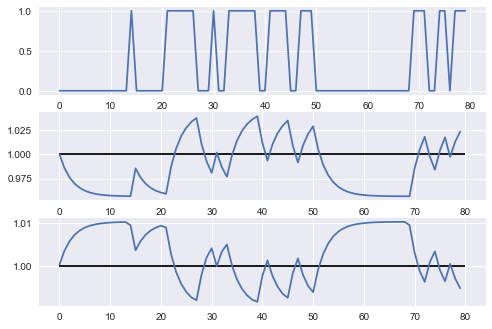

In [16]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(3,1)
ax[0].plot(range(T), zt[:-1])
ax[1].plot(range(T), kt[:-1])
ax[1].hlines(1, 0, T)
ax[2].plot(range(T), ht)
ax[2].hlines(1, 0, T)   

--------------------------------------------------------------------------------------------------------------------------------

In [5]:
## implement AR(1)

def ar1(T, rho, sigma, zbar = 1):
    z = np.zeros(T)
    z[0] = np.log(zbar)
    
    for t in range(1,T):        
        z[t] = (1 - rho) * np.log(zbar) + rho * z[t-1] + sigma * np.random.normal()
        
    return z

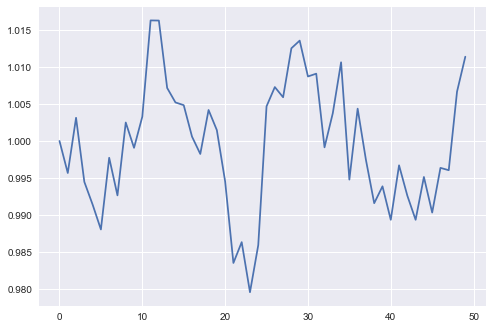

In [8]:
plt.plot(np.exp( ar1(50, 0.78, 0.0067) ) )

In [104]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply

## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)      # parameter for utility function
## initial capital stock
k0 = 0.8

rho = 0.78
sigma = 0.0067

params = {'beta': beta, 'nu': nu, 'eta': eta, 
          'alpha': alpha, 'delta': delta, 'A': A, 'B': B, 'rho': rho, 'sigma': sigma }

In [40]:
def u(c, h, pm):
    """
    Evaluates an additive-separable utility function with consumption and labor as arguments
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])

def f(k, h, pm):
    """
    Evaluates a Cobb-Douglas production function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return pm['A'] * k**pm['alpha'] * h**(1 - pm['alpha'])


def f_diff(k, h, pm):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return (pm['alpha'] * f(k, h, pm) / k, (1 - pm['alpha']) * f(k, h, pm) / h)


In [41]:
m = 10
k_min = 0.7
k_max = 1.3

k_grid = fa.chebgrid(k_min, k_max, m)

In [105]:
epsmax = 4 * sigma
z_max = np.exp(epsmax/(1-rho))
z_min = 1/z_max
# z_max= 1.001
# z_min = 0.999

z_grid = fa.chebgrid(z_min, z_max, 10)
print(z_grid)

[ 0.88681282  0.89861957  0.92107735  0.95198783  0.98832529  1.02653274
  1.0628702   1.09378068  1.11623846  1.12804521]


In [106]:
Z_grid, K_grid = np.meshgrid(z_grid, k_grid)

In [107]:
N = 8
nodes, weights = np.polynomial.hermite.hermgauss(N)
print(nodes)

[-2.93063742 -1.98165676 -1.15719371 -0.38118699  0.38118699  1.15719371
  1.98165676  2.93063742]


In [110]:
z_grid[0]**rho * np.exp(np.sqrt(2) * sigma * nodes)

array([ 0.88562372,  0.89362299,  0.90063129,  0.90727789,  0.9138555 ,
        0.9205997 ,  0.92781957,  0.93619997])

In [111]:
## set the degree of approximation
n = m - 1

## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(K_grid )
## compute implied basis coefficients
a0 = fa.chebapprox_2d(V0, [n, n])

In [112]:
def vf_rhs(x, k, z, coef, k_min, k_max, z_min, z_max, nodes, weights, pm):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[0])   # a scalar!
    h = np.exp(x[1])    # a scalar!
    
    zp = z**pm['rho'] * np.exp(np.sqrt(2) * pm['sigma'] * nodes)  # an array
    
    cv = np.zeros(N)
    for ind in range(N):
        cv[ind] = np.polynomial.chebyshev.chebval2d(fa.chebconvert(kp, k_min, k_max),
                                                    fa.chebconvert(zp[ind], z_min, z_max), coef)
    
    return (- u(z * f(k, h, pm) + (1 - pm['delta']) * k - kp, h, pm) 
            - beta * (np.pi)**(-0.5) * weights @ cv) 

In [113]:
vf_rhs([0,0], k0, z_grid[0], a0, k_min, k_max, z_min, z_max, nodes, weights, params)

1.4290013420271765

In [114]:
def opt_step(k_grid, z_grid, x0, a_ch, k_min, k_max, z_min, z_max, nodes, weights, pm):     
    """
    Function that loops over all states (= elements in k_grid and q_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros((m, m))
    K = np.zeros((m, m))
    H = np.zeros((m, m))
    
    ## loop
    for (ind1, k) in enumerate(k_grid):
        for (ind2, z) in enumerate(z_grid):
        ## optimization step
            res = scipy.optimize.minimize(vf_rhs, x0, args = (k, z, a_ch, k_min, k_max, z_min, z_max, nodes, weights, pm), method ='BFGS') 
            V[ind1, ind2] = - res.fun
            K[ind1, ind2], H[ind1, ind2]  = np.exp( res.x )
            if res.success is not True:
                print(k, z, res.message)
        
    return V, K, H

In [69]:
V, K, H = opt_step(k_grid, z_grid, x0, a0, k_min, k_max, z_min, z_max, nodes, weights, params)

In [77]:
a_new = fa.chebapprox_2d(V, [n, n])

In [103]:
# V, K, H = opt_step(k_grid, z_grid, x0, a_new, k_min, k_max, z_min, z_max, nodes, weights, params)

In [115]:
## initialize initial guess for basis coefficients and optimization
a_ch = a0.copy()
x0 = np.log([1, 1])

eps = 1
it = 0
maxit = 300

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, H = opt_step(k_grid, z_grid, x0, a_ch, k_min, k_max, z_min, z_max, nodes, weights, params)
    ## fitting step
    a_new = fa.chebapprox_2d(V, [n, n])
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()
    
    if it % 10 == 0:
        print(it, eps)

print(it, eps)

10 0.148676444419
20 0.0159683423424
30 0.00171466371268
40 0.000184111310429
50 1.97688076122e-05
60 2.12265962585e-06
70 2.27918758536e-07
80 2.44725892978e-08
85 8.01907876559e-09


In [116]:
a_k = fa.chebapprox_2d(K, [n, n])
a_h = fa.chebapprox_2d(H, [n, n])

In [120]:
## number of periods
T = 30
k0 = 1

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)

## initial capital stock is given
kt[0] = k0

zt = np.exp( ar1(T+1, params['rho'], params['sigma']) )

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_k )
    ht[t] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_h )

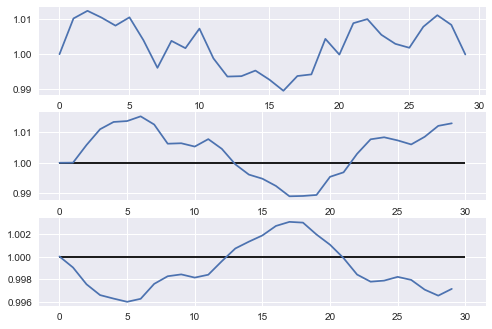

In [121]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(3,1)
ax[1].plot(range(T), kt[:-1])
ax[1].hlines(1, 0, T)
ax[0].plot(range(T), zt[:-1])
ax[2].plot(range(T), ht)
ax[2].hlines(1, 0, T) 

## Compute Moments

In [124]:
T = 10000
Tb = 1000

np.random.seed(1)
zt = np.exp( ar1(T+1, params['rho'], params['sigma']) )

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)
invt = np.zeros(T)
ct = np.zeros(T)
yt = np.zeros(T)

## initial capital stock is given
kt[0] = k0

zt = np.exp( ar1(T+1, params['rho'], params['sigma']) )

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_k )
    ht[t] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_h )

    yt[t] = zt[t] * f(kt[t], ht[t], params)
    invt[t] = kt[t + 1] - (1 - delta) * kt[t]
    ct[t] = yt[t] - invt[t]

#     moments = [np.std(np.log(yt[Tb:]) - np.log(ys)), np.std(np.log(ct[Tb:]) - np.log(cs)), \
#                np.std(np.log(invt[Tb:]) - np.log(invs)), np.std(np.log(lt[Tb:]) - np.log(ls)), \
#                np.std(np.log(kt[Tb:]) - np.log(ks))]
    
moments = [ np.std(np.log(ht[Tb:]) ), np.std(np.log(kt[Tb:]))]
    
print( moments )

[0.0040279151977391878, 0.014699242320928469]
